# init
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de

## Tasks
- get OpenStreetMap data using the osmnx functionalities in the Overpass API
- clip it to an AOI

## Prerequisites
- have osmnx and geopandas installed
- have an AOI saved as a vector (shapefile or geopackage)

In [1]:
import osmnx as ox
import geopandas as gpd
from pathlib import Path

# imports

In [3]:
#import the AOI
AOI_path = Path('../data/processed/')
AOI_file = 'LIM_rs_floods_2024_bbox_A.shp'
AOI_gdf = gpd.read_file(AOI_path / AOI_file)

In [4]:
#bounds provides minx, miny, maxx, maxy
aoi_coords = AOI_gdf.to_crs(epsg='4326').envelope
bbox_df = gpd.GeoDataFrame(geometry=aoi_coords)
print('N',aoi_coords.bounds.values[0][3],'S',aoi_coords.bounds.values[0][1],'W',aoi_coords.bounds.values[0][0],'E',aoi_coords.bounds.values[0][2])

N -28.151368971300695 S -30.821933005380856 W -53.73325726119012 E -49.90019408378721


In [6]:
#get road features from OSM
# List key-value pairs for tags
# Wiki url https://wiki.openstreetmap.org/wiki/Key:highway
tags = {'highway': ['primary', 'secondary', 'tertiary', 'residential', 'unclassified', 'trunk', 'motorway']}
col_list = ['osmid','name','source','geometry', 'highway','surface','lanes','incline'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns

roads = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                              south=aoi_coords.bounds.values[0][1],
                              west=aoi_coords.bounds.values[0][0],
                              east=aoi_coords.bounds.values[0][2],
                              tags=tags)
roads.reset_index(inplace=True)

#filtering out the wrong geometries (POLYGON or POINT) and element types (NODE)
roads = roads.loc[(roads.geometry.type=='LineString')&(roads.element_type == 'way'), col_list]
#convert the CRS of roads to the same as AOI
roads.to_crs(AOI_gdf.crs,inplace=True)

#plot them
roads.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', linewidth=1, zorder=2)

C:\Users\ra42zek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\osmnx\_overpass.py:211: UserWarning: This area is 43 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


ChunkedEncodingError: ('Connection broken: IncompleteRead(82 bytes read, 8014 more expected)', IncompleteRead(82 bytes read, 8014 more expected))

<Axes: >

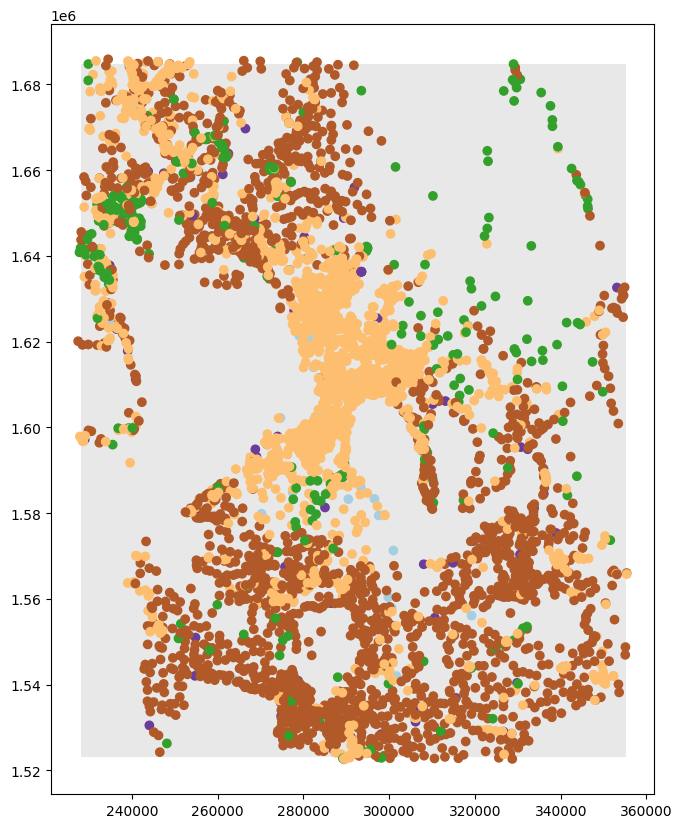

In [5]:
# get points with place names from OSM
# List key-value pairs for tags
tags = {'place': ['city', 'town', 'village', 'hamlet','neighbourhood']} # see https://wiki.openstreetmap.org/wiki/Key:place for more info
col_list = ['osmid','name','geometry', 'place','population'] #OSM has hundreds of cols, we just want a few. For info, check roads.columns'source',

places = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                              south=aoi_coords.bounds.values[0][1],
                              west=aoi_coords.bounds.values[0][0],
                              east=aoi_coords.bounds.values[0][2],
                              tags=tags)
places.reset_index(inplace=True)

#filtering out the wrong geometries (POLYGON or POINT) and element types (NODE)
places = places.loc[(places.geometry.type=='Point'), col_list] #&(places.element_type == 'way')
#convert the CRS of roads to the same as AOI
places.to_crs(AOI_gdf.crs,inplace=True)

#plot them
places.plot('place',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired',  zorder=2) #linewidth=1,

<Axes: >

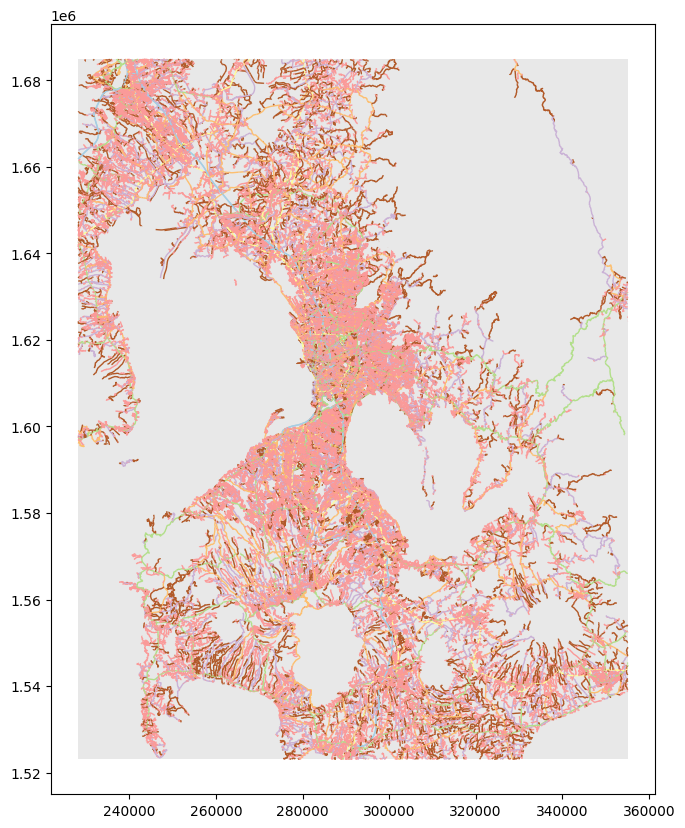

In [6]:
#clip using geopandas, the mask is the AOI we imported above
clipped_gdf = gpd.clip(roads, mask=AOI_gdf, keep_geom_type=True)
clipped_gdf.plot('highway',ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', linewidth=1, zorder=2)

# export

In [7]:
#export roads  to a shapefile
clipped_gdf.to_file(AOI_path / 'MAN_TRA_roads_OSM_2024_L.shp')

In [8]:
#export places to a shapefile
places.to_file(AOI_path / 'MAN_LOC_places_OSM_2024_P.shp')